#### Anomaly Detection Example based on this introductory blog post
https://blog.floydhub.com/introduction-to-anomaly-detection-in-python/

In [1]:
# Import the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Comment out the following line if you are using Jupyter Notebook
# %matplotlib inline
# Use a predefined style set
plt.style.use('ggplot')

In [3]:
!pip install faker

     |████████████████████████████████| 880kB 4.6MB/s 
     |████████████████████████████████| 81kB 42.3MB/s 
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
# Import Faker
from faker import Faker
fake = Faker()

# To ensure the results are reproducible
fake.seed(4321)

names_list = []

fake = Faker()
for _ in range(100):
  names_list.append(fake.name())

# To ensure the results are reproducible
np.random.seed(7)

salaries = []
for _ in range(100):
    salary = np.random.randint(1000,2500)
    salaries.append(salary)

# Create pandas DataFrame
salary_df = pd.DataFrame(
    {'Person': names_list,
     'Salary (in USD)': salaries
    })

# Print a subsection of the DataFrame
print(salary_df.head())

              Person  Salary (in USD)
0        Jason Brown             1175
1        Jacob Stein             2220
2         Cody Brown             1537
3      Larry Morales             1502
4  Jessica Hendricks             1211


#### manually change the salary entries of two individuals

In [5]:
salary_df.at[16, 'Salary (in USD)'] = 23
salary_df.at[65, 'Salary (in USD)'] = 17

# Verify if the salaries were changed
print(salary_df.loc[16])
print(salary_df.loc[65])

Person             Miss Amanda Harris MD
Salary (in USD)                       23
Name: 16, dtype: object
Person             Joyce Bishop
Salary (in USD)              17
Name: 65, dtype: object


#### Graphical anomaly detection

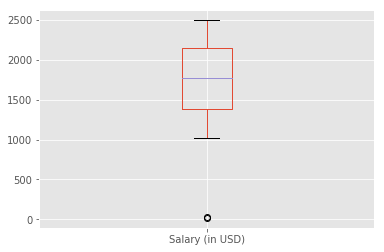

In [6]:
# Generate a Boxplot
salary_df['Salary (in USD)'].plot(kind='box')
plt.show()

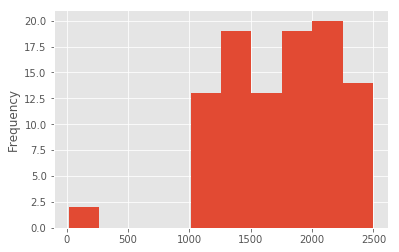

In [7]:
# Generate a Histogram plot
salary_df['Salary (in USD)'].plot(kind='hist')
plt.show()

#### Now with some stats

In [8]:
# Minimum and maximum salaries
print('Minimum salary ' + str(salary_df['Salary (in USD)'].min()))
print('Maximum salary ' + str(salary_df['Salary (in USD)'].max()))

Minimum salary 17
Maximum salary 2498


#### Clustering based approach 

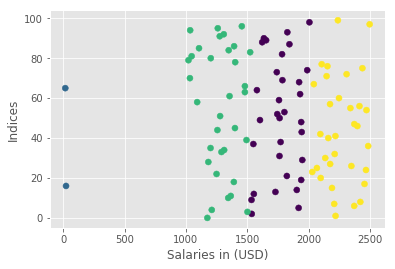

In [13]:
# Convert the salary values to a numpy array
salary_raw = salary_df['Salary (in USD)'].values

# For compatibility with the SciPy implementation
salary_raw = salary_raw.reshape(-1, 1)
salary_raw = salary_raw.astype('float64')

# Import kmeans from SciPy
from scipy import cluster
from scipy.cluster.vq import kmeans
    
# Specify the data and the number of clusters to kmeans()
centroids, avg_distance = kmeans(salary_raw, 4)

# Get the groups (clusters) and distances
groups, cdist = cluster.vq.vq(salary_raw, centroids)

plt.scatter(salary_raw, np.arange(0,100), c=groups)
plt.xlabel('Salaries in (USD)')
plt.ylabel('Indices')
plt.show()

#### classification approach

In [15]:
# First assign all the instances to 
salary_df['class'] = 0

# Manually edit the labels for the anomalies
salary_df.at[16, 'class'] = 1
salary_df.at[65, 'class'] = 1

# Veirfy 
print(salary_df.loc[16])

Person             Miss Amanda Harris MD
Salary (in USD)                       23
class                                  1
Name: 16, dtype: object


In [16]:
salary_df.head()

,Person,Salary (in USD),class
0,Jason Brown,1175,0
1,Jacob Stein,2220,0
2,Cody Brown,1537,0
3,Larry Morales,1502,0
4,Jessica Hendricks,1211,0


In [19]:
!pip install pyod

     |████████████████████████████████| 92kB 6.1MB/s 
  Stored in directory: /home/ubuntu/.cache/pip/wheels/30/2f/4a/90c7bf3403325384b1c2ef5eb50d65d7467b8dd1b64a92ab82
Successfully built pyod
You should consider upgrading via the 'pip install --upgrade pip' command.


In [20]:
# Importing KNN module from PyOD
import pyod
from pyod.models.knn import KNN

# Segregate the salary values and the class labels 
X = salary_df['Salary (in USD)'].values.reshape(-1,1)
y = salary_df['class'].values

# Train kNN detector
clf = KNN(contamination=0.02, n_neighbors=5)
clf.fit(X)

# Get the prediction labels of the training data
y_train_pred = clf.labels_ 
    
# Outlier scores
y_train_scores = clf.decision_scores_

# Import the utility function for model evaluation
from pyod.utils import evaluate_print

# Evaluate on the training data
evaluate_print('KNN', y, y_train_scores)

KNN ROC:1.0, precision @ rank n:1.0


In [21]:
# A salary of $37 (an anomaly right?)
X_test = np.array([[37.]])

# Check what the model predicts on the given test data point
clf.predict(X_test)

array([1])

In [22]:
# A salary of $1256
X_test_abnormal = np.array([[1256.]])

# Predict
clf.predict(X_test_abnormal)

array([0])